In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Text(0, 0.5, 'y')

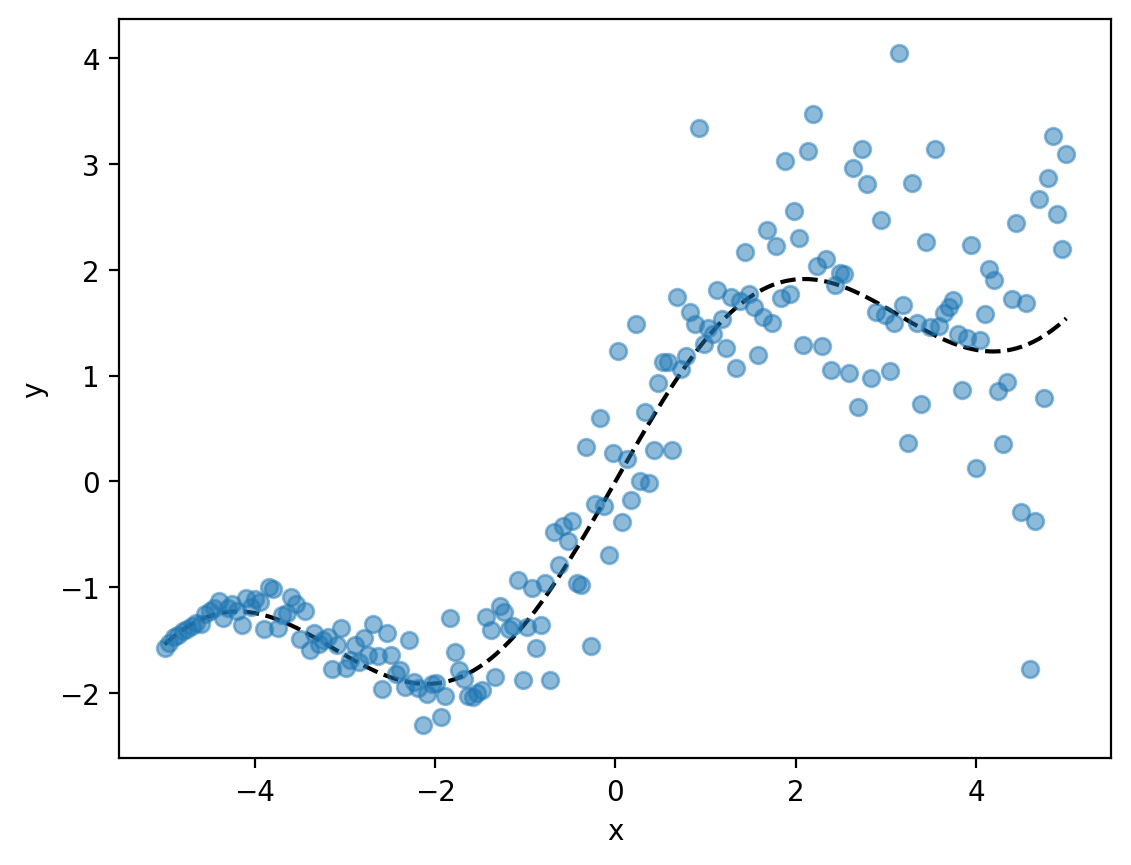

In [17]:
# Generating data with heteroscedastic noise
x_lin = torch.linspace(-5, 5, 200)
f_true = lambda x: torch.sin(x) + 0.5 * x
eps = torch.randn_like(x_lin)*0.1*(x_lin+5) + 0.1*torch.cos(x_lin)*0.1*(x_lin-5)
y_lin = f_true(x_lin) + eps

plt.plot(x_lin, f_true(x_lin), 'k--')
plt.plot(x_lin, y_lin, 'o', alpha=0.5)
plt.xlabel('x')
plt.ylabel('y')


In [23]:
# Define a simple neural network with three outputs corresponding to the three quantiles

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, 20)
        self.fc2 = nn.Linear(20, 3)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def loss(y_pred, y, tau):
    e = -1*(y_pred - y) #check for sign
    return torch.mean(torch.max(tau*e, (tau-1)*e))

net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.01)


In [24]:
net(x_lin[0].reshape(-1, 1))

tensor([[-1.3076, -1.6280, -0.6429]], grad_fn=<AddmmBackward0>)

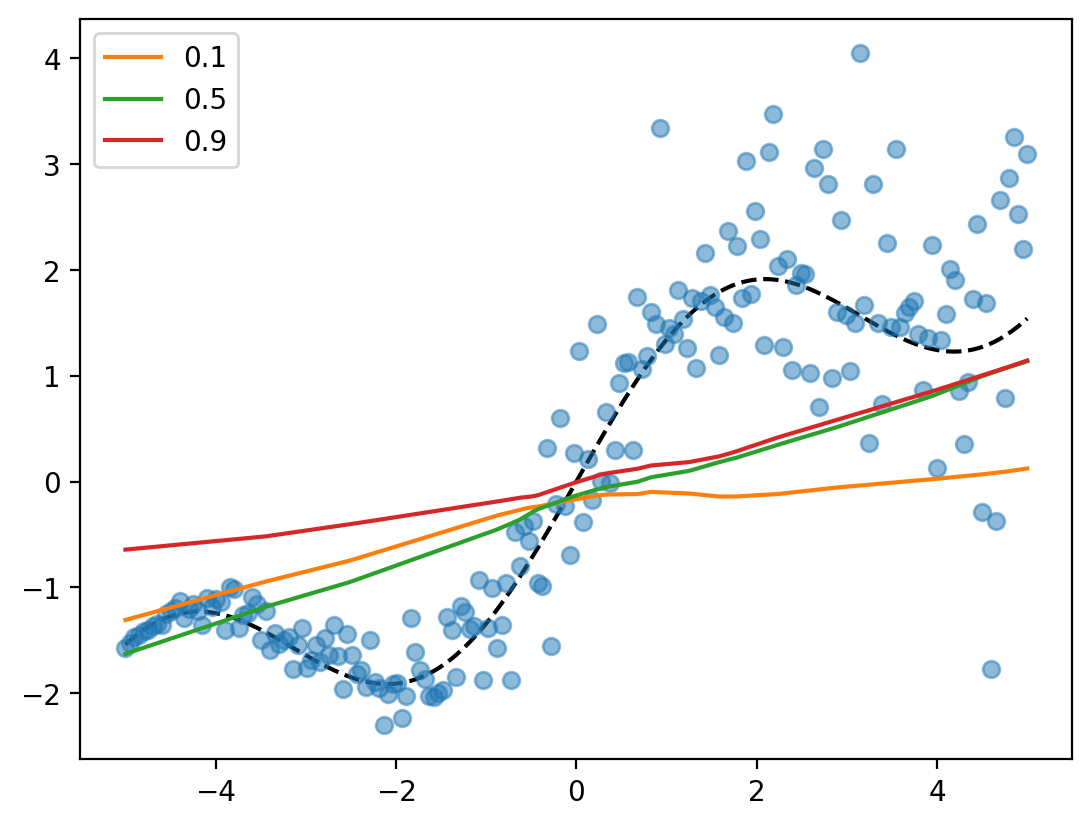

In [25]:
taus = [0.1, 0.5, 0.9]

# Plot the predictions of the network before training
def plot_quantiles(net):
    y_pred = net(x_lin.reshape(-1, 1))
    plt.plot(x_lin, f_true(x_lin), 'k--')
    plt.plot(x_lin, y_lin, 'o', alpha=0.5)
    for i, tau in enumerate(taus):
        plt.plot(x_lin, y_pred[:, i].detach(), label=tau)
    plt.legend()
plot_quantiles(net)

In [26]:
for epoch in range(200):
    optimizer.zero_grad()
    y_pred = net(x_lin.unsqueeze(1))
    loss_val = sum([loss(y_pred[:, i], y_lin, tau) for i, tau in enumerate(taus)])
    loss_val.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch {}: loss {}'.format(epoch, loss_val.item()))

Epoch 0: loss 1.4152570962905884
Epoch 100: loss 0.4124695360660553


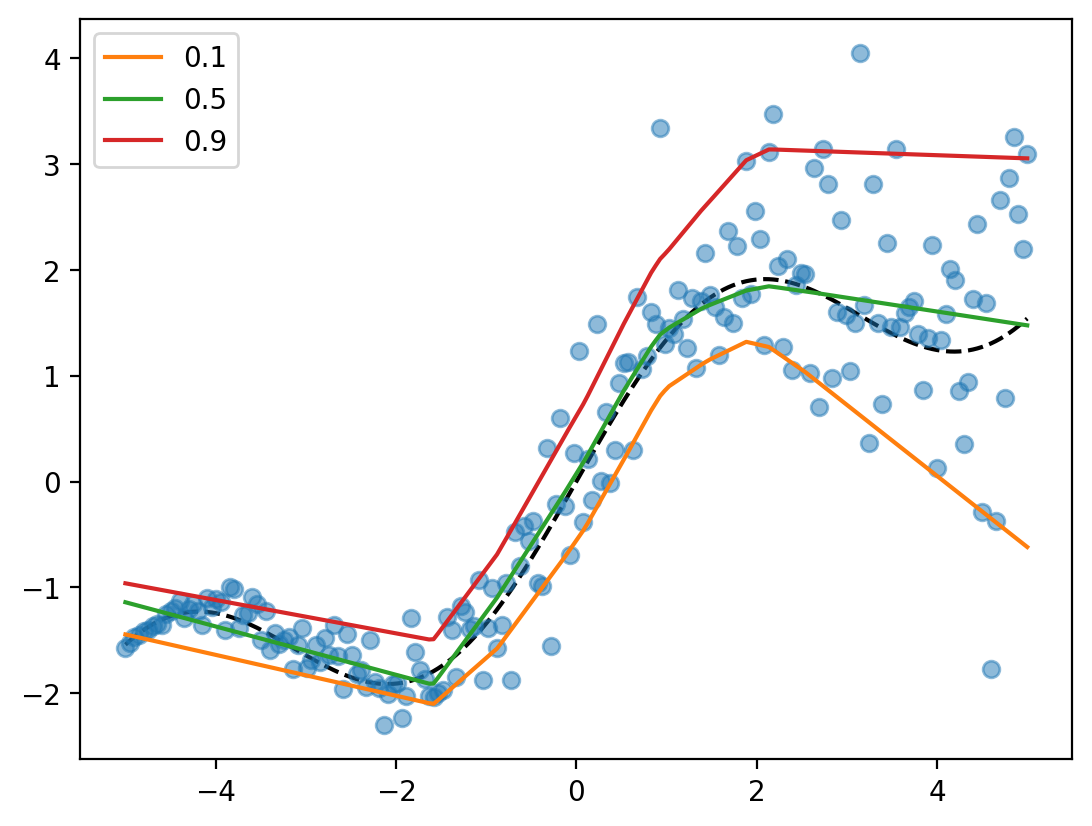

In [27]:
plot_quantiles(net)

In [33]:
for i, tau in enumerate(taus):
    print(f'Fraction of points lesser than {tau}th quantile: {(y_lin < y_pred[:, i]).float().mean():0.2f}')

Fraction of points lesser than 0.1th quantile: 0.08
Fraction of points lesser than 0.5th quantile: 0.49
Fraction of points lesser than 0.9th quantile: 0.90
